# Оценка неопределенностей в задачах машинного обучения

&nbsp;

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import datetime

In [5]:
from tqdm import tqdm

In [6]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

In [7]:
class linear_regression:
    def __init__(self):
        self.theta = None
        pass
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
        
        # attaching ones as first column-vector - x[:,0]
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        # making y_train of shape (N,1)
        y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_matrix.T, X_matrix)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_matrix.T)
        theta_star = np.dot(m3, y_column)
        self.theta = theta_star
    
    def predict(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert self.theta is not None, "theta is None. perhaps, fit the model first."
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        y_pred = np.dot(X_matrix, self.theta)
        return y_pred

## здесь будут генерироваться синтетические данные для задачи линейной регрессии
Эти данные моделируют линейную зависимость с вектором коэффициентов $\theta$ и задаваемой матрицей ковариаций для признаков $x^{(1)}$ и $x^{(2)}$:
$$
\theta=\begin{bmatrix}
2.33 \\
0.67 \\
-1.35
\end{bmatrix}
$$

По умолчанию (если не задана) матрица ковариаций следующая:
$$
R=\begin{bmatrix}
1.0 & 2.94\\
2.94 & 9.0
\end{bmatrix}
$$

Шум в данных моделируется следующим образом:
$$
\epsilon \sim \mathcal{N}(0, \sigma^2)\\
\sigma^2 = 1
$$

In [8]:
theta_true = np.array([[2.33, 0.67, -1.35]])
epsilon_var = 1.0
default_cov_matrix = np.array([[1.0, 2.94],[2.94, 9.0]])
def generate_data(train_sample_size = 10000, test_sample_size = 1000, cov_matrix = default_cov_matrix):
    
    X = np.random.multivariate_normal([0.0, 0.0], cov_matrix, train_sample_size)
    X_test = np.random.multivariate_normal([0.0, 0.0], cov_matrix, test_sample_size)
    
    Xtrain_extended = np.hstack([np.ones((X.shape[0],1)), X])
    y = np.dot(Xtrain_extended, theta_true.T) + np.random.randn(Xtrain_extended.shape[0],1)*np.sqrt(epsilon_var)
    
    Xtest_extended = np.hstack([np.ones((X_test.shape[0],1)), X_test])
    y_test = np.dot(Xtest_extended, theta_true.T) + np.random.randn(Xtest_extended.shape[0],1)*np.sqrt(epsilon_var)
    
    return X,y,X_test,y_test

&nbsp;

### сгенерируем данные и проанализируем их

представим, что мы не знаем, что за закономерность генерирует данные

In [9]:
X,y,X_test,y_test = generate_data()

In [10]:
np.corrcoef(X.T)

array([[1.        , 0.98036045],
       [0.98036045, 1.        ]])

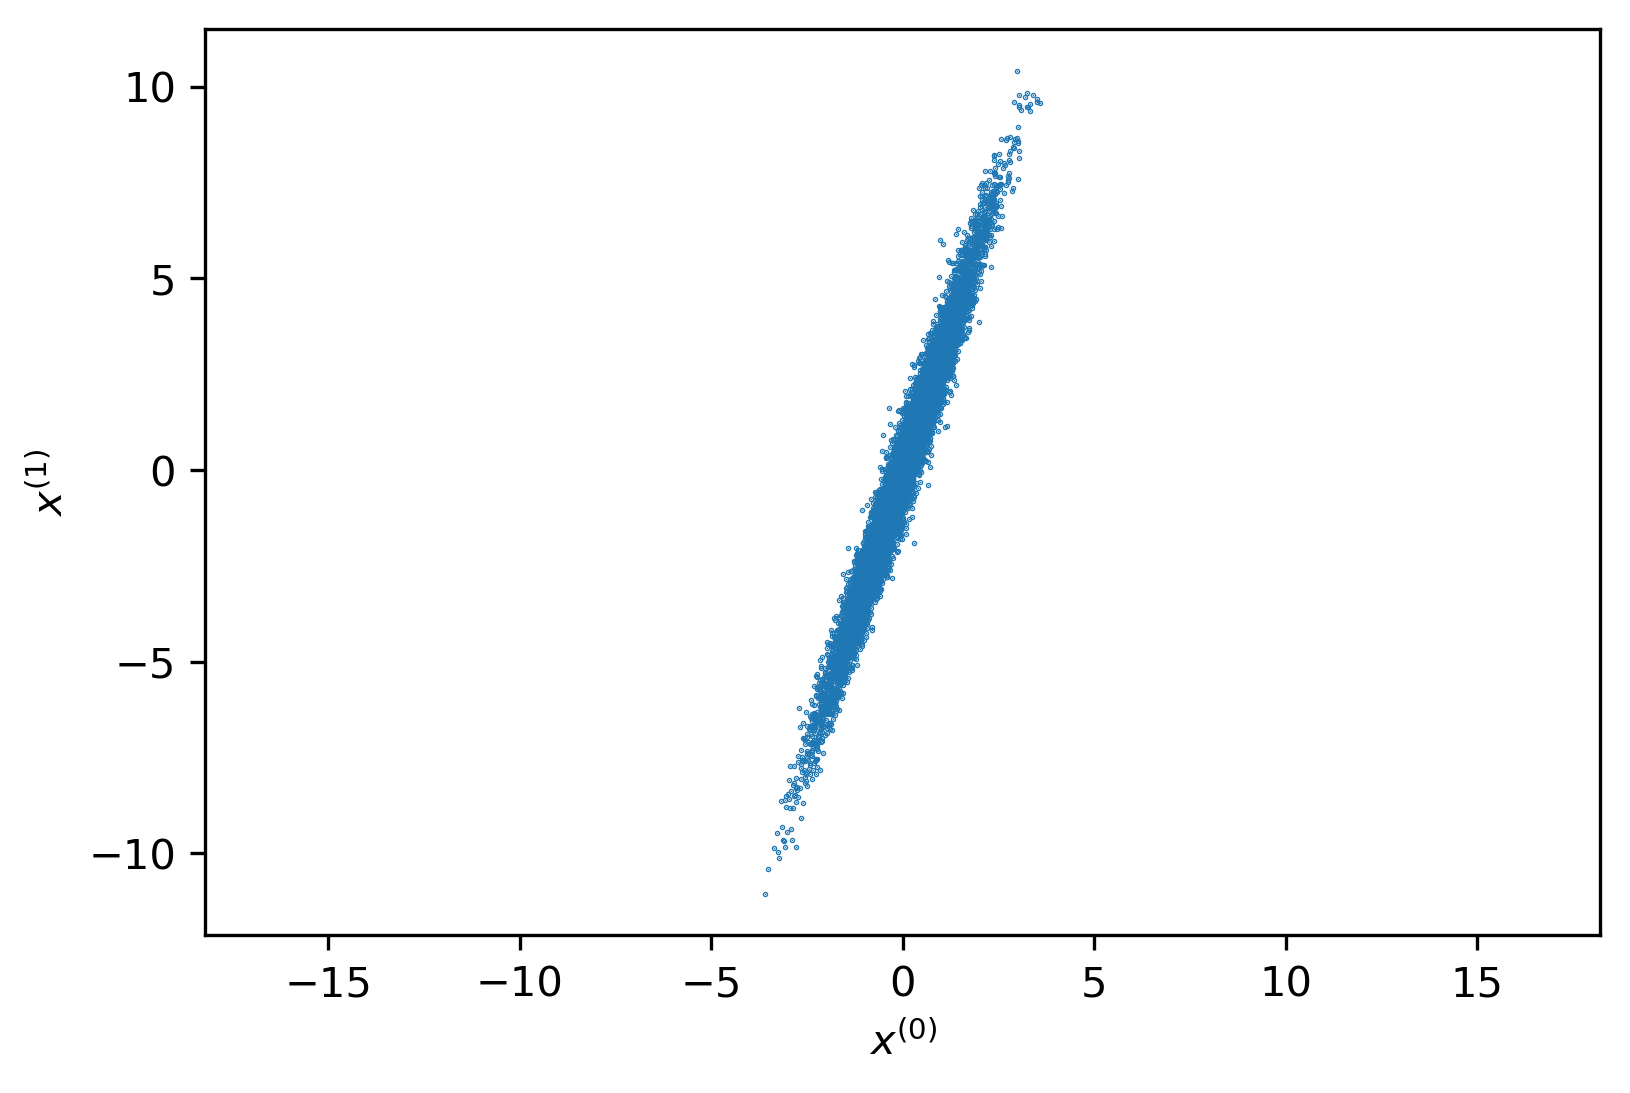

In [11]:
plt.scatter(X[:,0], X[:,1],s=0.1)
plt.xlabel('$x^{(0)}$')
plt.ylabel('$x^{(1)}$')
_ = plt.axis('equal')

In [12]:
lr = linear_regression()

In [13]:
lr.fit(X,y)

In [14]:
lr.theta

array([[ 2.3353475 ],
       [ 0.60775609],
       [-1.32889186]])

In [15]:
theta_true

array([[ 2.33,  0.67, -1.35]])

<br /><br />

## оценим качество "финальной" модели на тестовой выборке

In [16]:
y_pred = lr.predict(X_test)

In [17]:
np.std((y_pred-y_test))

0.9778790383784179

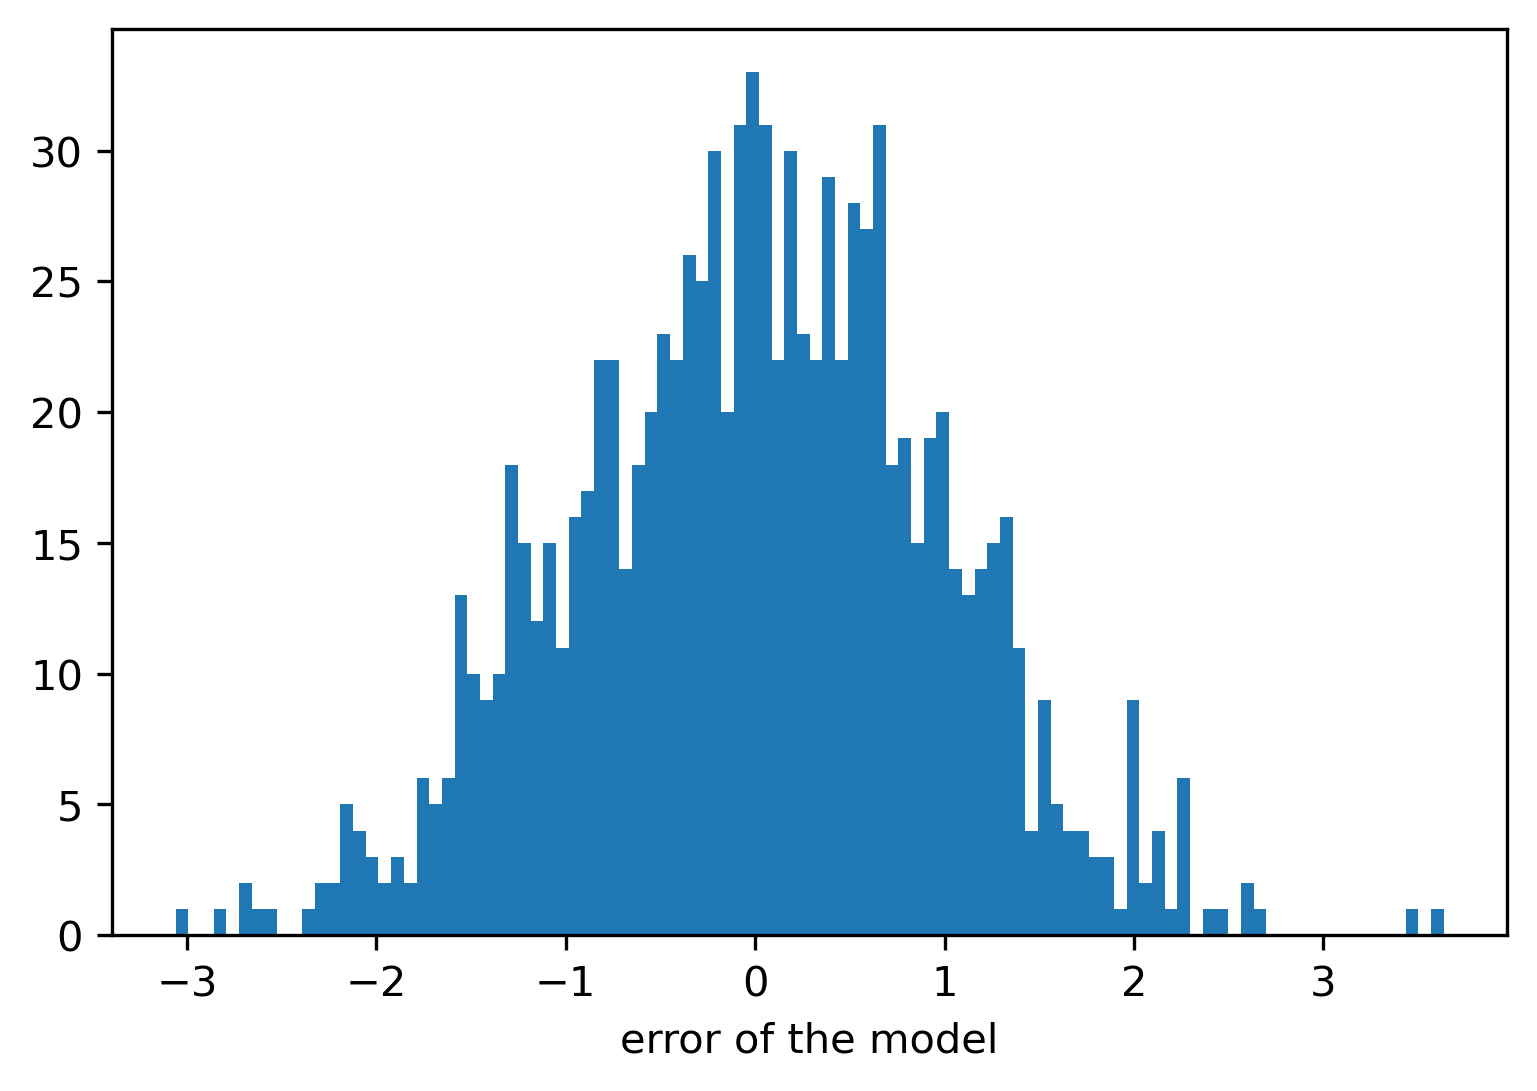

In [18]:
_ = plt.hist((y_pred-y_test), bins=100)
_ = plt.xlabel('error of the model')

## !!!
Эта оценка стандартного отклонения не обязательно говорит о том, плохая модель или хорошая модель. Сравните это стандартное отклонение со значением $\sigma$, которым моделируется шум в данных при генерации.

В реальных задачах мы, конечно, не знаем параметров шума. Но сейчас - знаем.

На этом синтетическом примере можно понять, что оценка качества, полученная на тестовой выборке, может ввести в заблуждение относительно реального качества модели.

<br /><br />

# Виды неопределенности аппроксимированой целевой переменной
### Алеаторическая неопределенность
Алеаторическая - неопределенность, наследуемая из неопределенности в данных. В рассматриваемой модели линейной регрессии алеаторической неопределенности соответствует ошибка, наследуемая от шума $\epsilon \sim \mathcal{N}(0, \sigma^2)$<br />
Алеаторическую неопределенность **невозможно снизить**. Это базовое свойство той закономерности, которая порождает данные. Можно рассматривать другую закономерность (другую постановку задачи, другой дизайн эксперимента). Но это будет уже другая задача, другая история.

### Эпистемическая неопределенность
Эпистемическая - неопределенность, обусловленная недостаточносностью знаний, сведений, способностей модели, *etc*. В рассматриваемой модели линейной регрессии эпистемической соответствует неопределенность, обусловленная чувствительностью модели к выбросам, надостаточной выразительностью модели, недостаточной обобщающей способностью модели, плохим балансом между обобщающей способностью и выразительностью модели, малым количеством данных.
Эпистемическую неопределенность можно и нужно снижать. Среди путей снижения эпистемической неопределенности в задаче регрессии:

- Увеличение выборки (data mining);
- Фильтрация выбросов в данных (предобработка данных);
- Отбор вида модели: выбор модели, менее чувствительной к выбросам в данных, обладающей лучшей обобщающей способностью, обладающей лучшей выразительностью; правильный подбор гиперпараметров, отвечающих за баланс между обобщающей способностью и выразительностью модели;

<br />

### Помимо оценки качества "финальной" модели обязательно нужно оценивать эпистемическую неопределенность
Именно эта неопределенность характеризует, насколько хорошо подходит эта модель для описания имеющихся данных.

Ошибка (качество) модели - оценивается на тестовой выборке. В оценке ошибки модели заложены оба типа неопределенности. Оценка качества модели по какой-то мере качества (например, MSE) - это оценка ошибки **одного** варианта модели, оптимизированного на **конкретной** тренировочной выборке.

**Идеальная модель** имеет ошибку, совпадающую с алеаторичской неопределенностью (шумом в данных, $\epsilon$).

<b>НО!!!</b><br />
В настоящий момент НЕТ простого способа разделить алеаторическую и эпистемическую неопределенности.<br />
Способы разделения этих неопределенностей - открытая область исследований. Наиболее продвинутые результаты получены с применением байесовских подходов (не рассматриваются в этом курсе)

Оценивать неопределенности модели будем с применением подхода **bootstrap**

## Bootstrap (бутстрэп, бутстреп)

**Bootstrap** - метод сэмплирования из выборки, предоставляющий возможность оценивать статистики на сокращенной выборке.

**Bootstrap** - метод сэмплирования с возвратом:

1. Определиться с размером bootstrap-выборки $N_b$
2. Повторять до тех пор, пока размер bootstrap-выборки не достигнет $N_b$:
    - Выбрать произвольный элемент исходной выборки, "вернуть" его на место.
    - Добавить выбранный элемент в bootstrap-выборку.

<br />

## Оценка качества модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку. Оставшиеся события - т.н. out-of-bag выборка (OOB)<br />
    b. Оптимизировать модель на этой выборке как на тренировочной<br />
    c. Оценить качество модели по выбранной мере качества на OOB-выборке.<br />
4. Оценить качество модели как среднее оценок, получаемых в п.**3.c.**

Получаемая таким образом оценка ошибки включает алеаторическую и эпистемическую неопределенности.

<br />

## Оценка значений и неопределенностей параметров модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку.<br />
    b. Оптимизировать модель на этой выборке как на тренировочной, записать полученные параметры.<br />
4. Оценить значения параметров модели как выборочную оценку среднего для параметров, получаемых в п.**3.b.**
5. Оценить неопределенность параметров модели как выборочную оценку стандартного отклонения параметров, получаемых в п.**3.b.**

<br />

## Оценка неопределенности вывода модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку<br />
    b. Оптимизировать модель на этой выборке как на тренировочной. Записать значения параметров.<br />
4. На новых элементах, к которым следует применить модель, оценивать эпистемическую неопределенность модели следующим образом:
    a. Применить модель в новому объекту с каждым из наборов параметров модели, полученных на этапе **3.b**. ВНИМАНИЕ! Эти значения - аппроксимация целевой переменной **без учета шума $\epsilon$**. То есть, это оценка среднего значения $y_i = \theta\bar{x_i}$ <br/>
    b. Если есть обоснованные предположения относительно параметров распределения шума $\epsilon$ - к каждому значению полученного среднего следует добавить шум.
    b. Оценить неопределенность полученных значений как выборочную оценку стандартного отклонения.

### ВАЖНО
Это НЕ эпистемическая неопределенность (см. выше - надежного способа разделить алеаторическую и эпистемическую у нас сейчас нет). Но как минимум это наша наилучшая попытка ее оценить.

<br />

## Оценка доверительных интервалов с применением подхода Bootstrap
Здесь приводится схема оценки доверительного интервала для статистик на OOB-выборке и для аппроксимированных значений целевой переменной.
- В случае, если нужно оценивать доверительный интервал аппроксимации целевой переменной с уровнем доверия p (например 0.95), оценка производится аналогично оценке неопределенности вывода модели (см. выше). Вместо выборочной оценки стандартного отклонения оцениваются эмпирические квантили (в приведенном примере - 0.025 и 0.975).


- В случае, если нужно оценивать доверительный интервал какой-то статистики, отражающей качество модели (например, MSE), поступают следующим образом:


1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку, получить OOB-выборку<br />
    b. Оптимизировать модель на этой выборке как на тренировочной. Оценить MSE на OOB-выборке, записать это значение.<br />
4. По набору значений MSE (количеством $B$) оценивается выборочное среднее, которое принимается за среднюю оценку качества модели по этой метрике (см. выше - "Оценка качества модели с применением подхода Bootstrap")
5. По набору значений MSE (количеством $B$) оцениваются эмпирические квантили (в приведенном примере при уровне доверия 0.95 - квантили 0.025 и 0.975), которые считаются границами доверительного интервала для MSE.

### ВАЖНО
Как и в случае с неопределенностью, оцениваемой как стандартное отклонение, - этот доверительный интервал не характеризует эпистемическую неопределенность модели. Но на настоящий момент это наша лучшая попытка ее оценить.

<br />

#### функции, которые могут быть полезны при реализации bootstrap:
[numpy.random.randint](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randint.html)<br />
[numpy.random.choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html#numpy.random.choice)

## --- Задание: реализовать функцию bootstrap-сэмплирования

In [19]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices, :], X[oob_indices, :], y[oob_indices, :]
    else:
        return X[sample_indices, :], y[sample_indices, :]

<br />

## Оценка неопределенности параметров модели

In [20]:
B = 1000

In [21]:
sample_size = 10
theta_values_curr_sample_size = []
for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 22434.11it/s]


In [22]:
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 3)

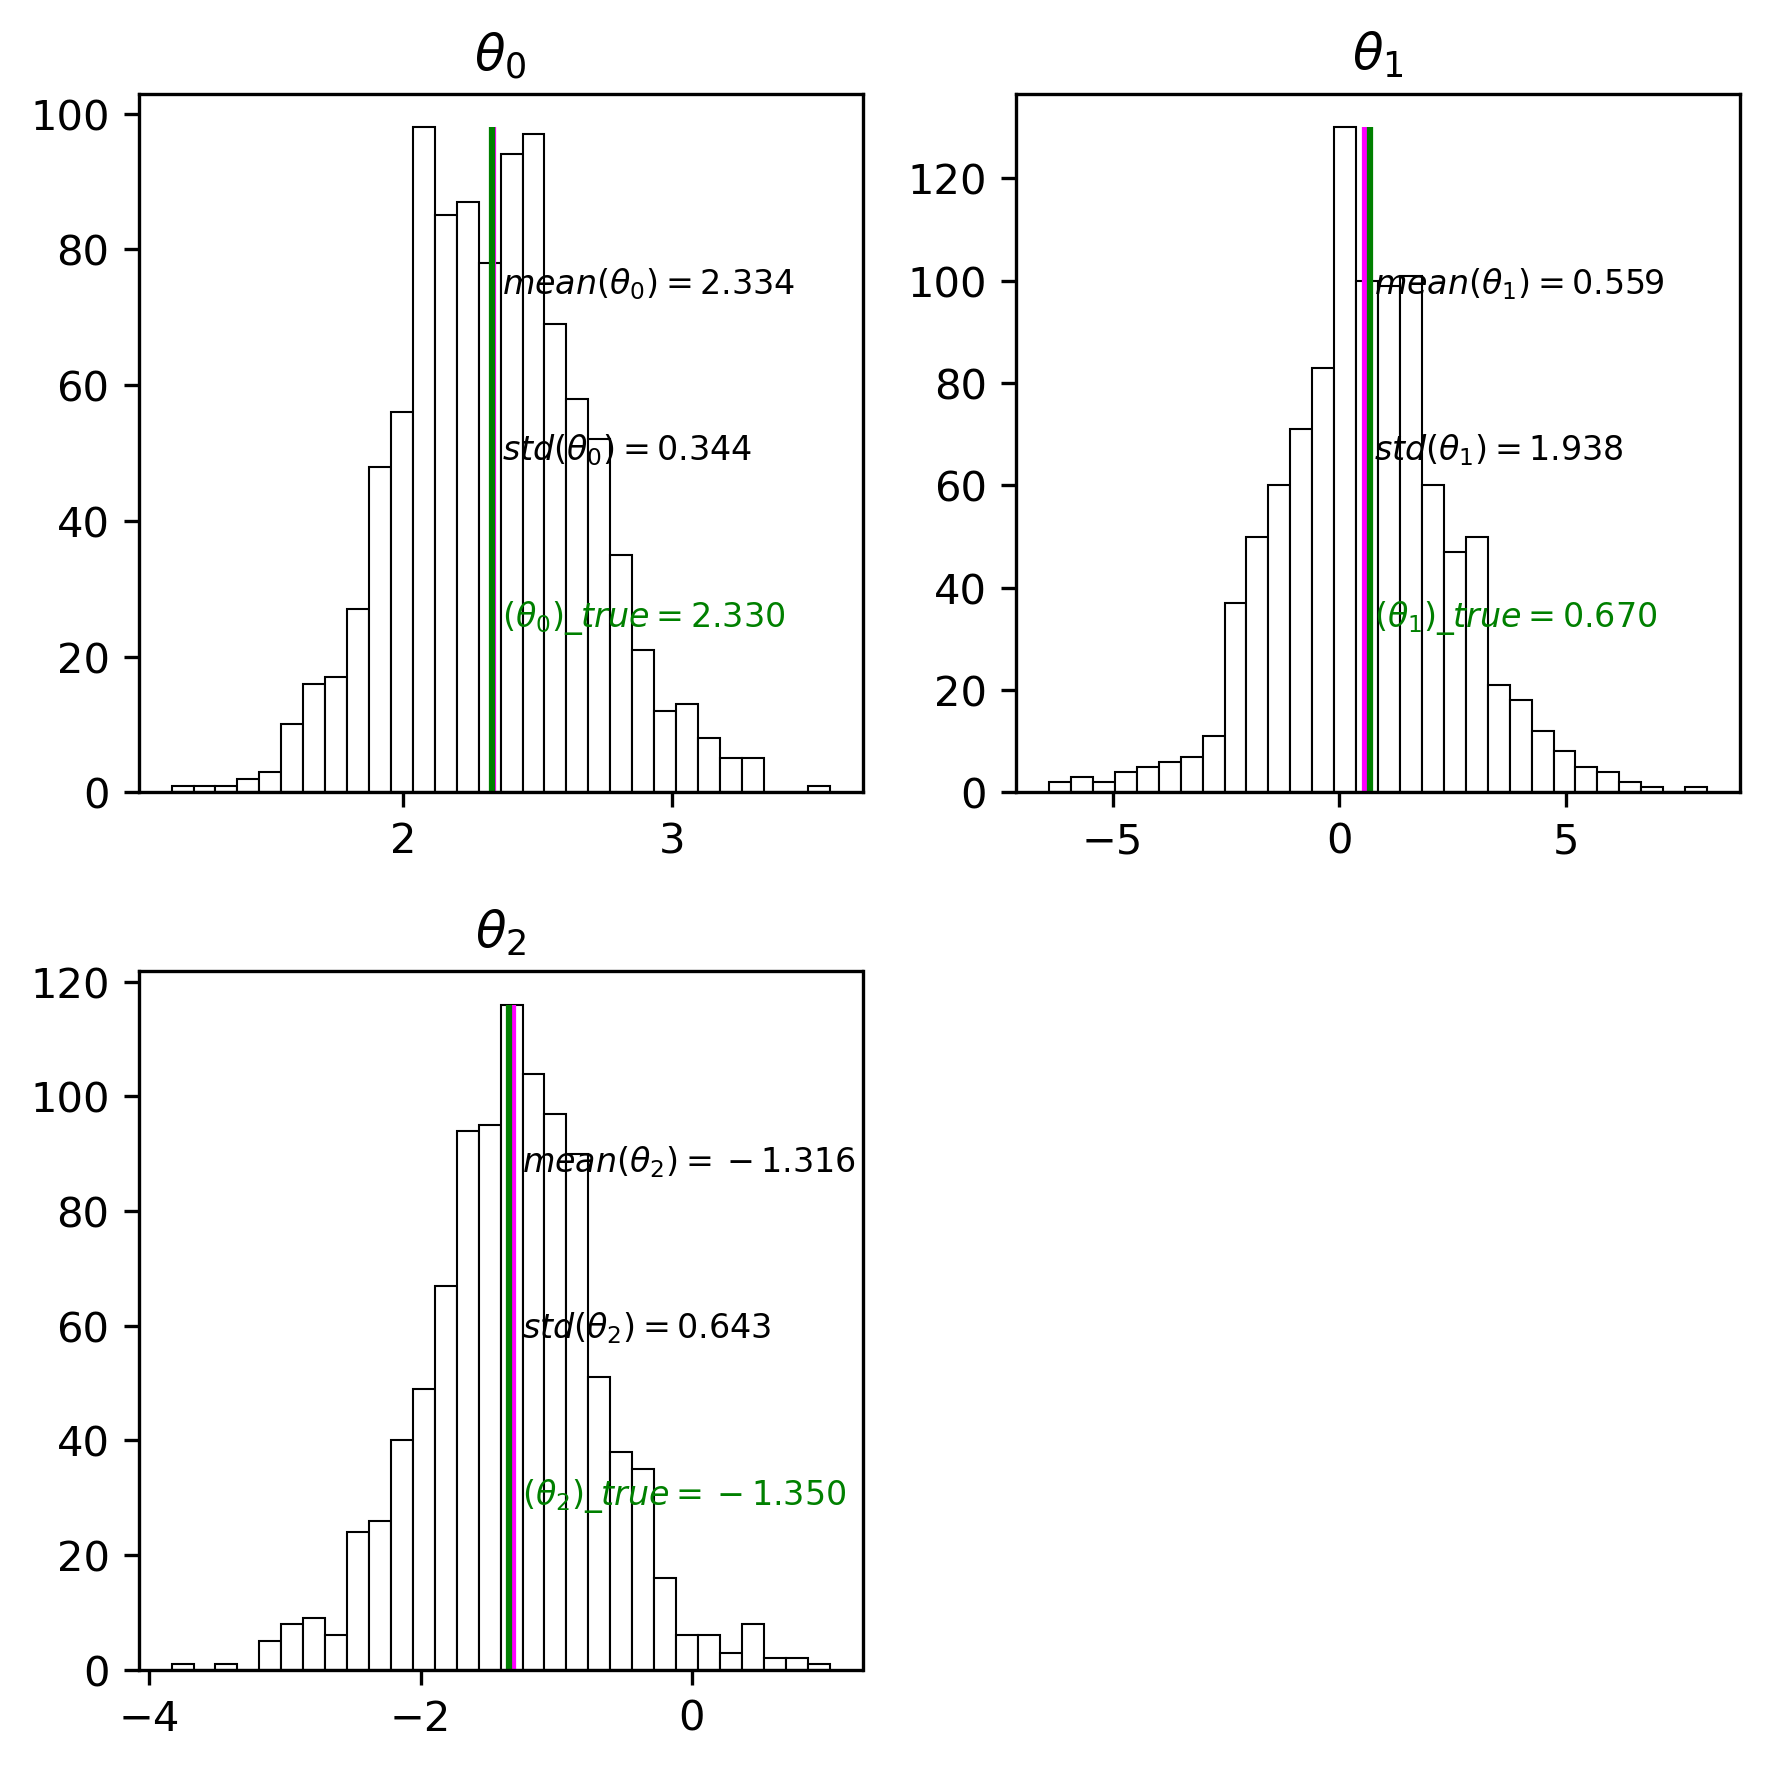

In [23]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(3):
    _ = plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    _ = plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    _ = plt.vlines(theta_true[0,i], 0, h_counts.max(), color='green')
    _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 1*h_counts.max()/4, '$(\\theta_%d)\_true = %.3f$' % (i, theta_true[0,i]), fontsize=8, color='green', weight='bold')
_ = plt.tight_layout()

<br />

In [24]:
sample_size = 100
theta_values_curr_sample_size = []
for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16516.39it/s]


In [25]:
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 3)

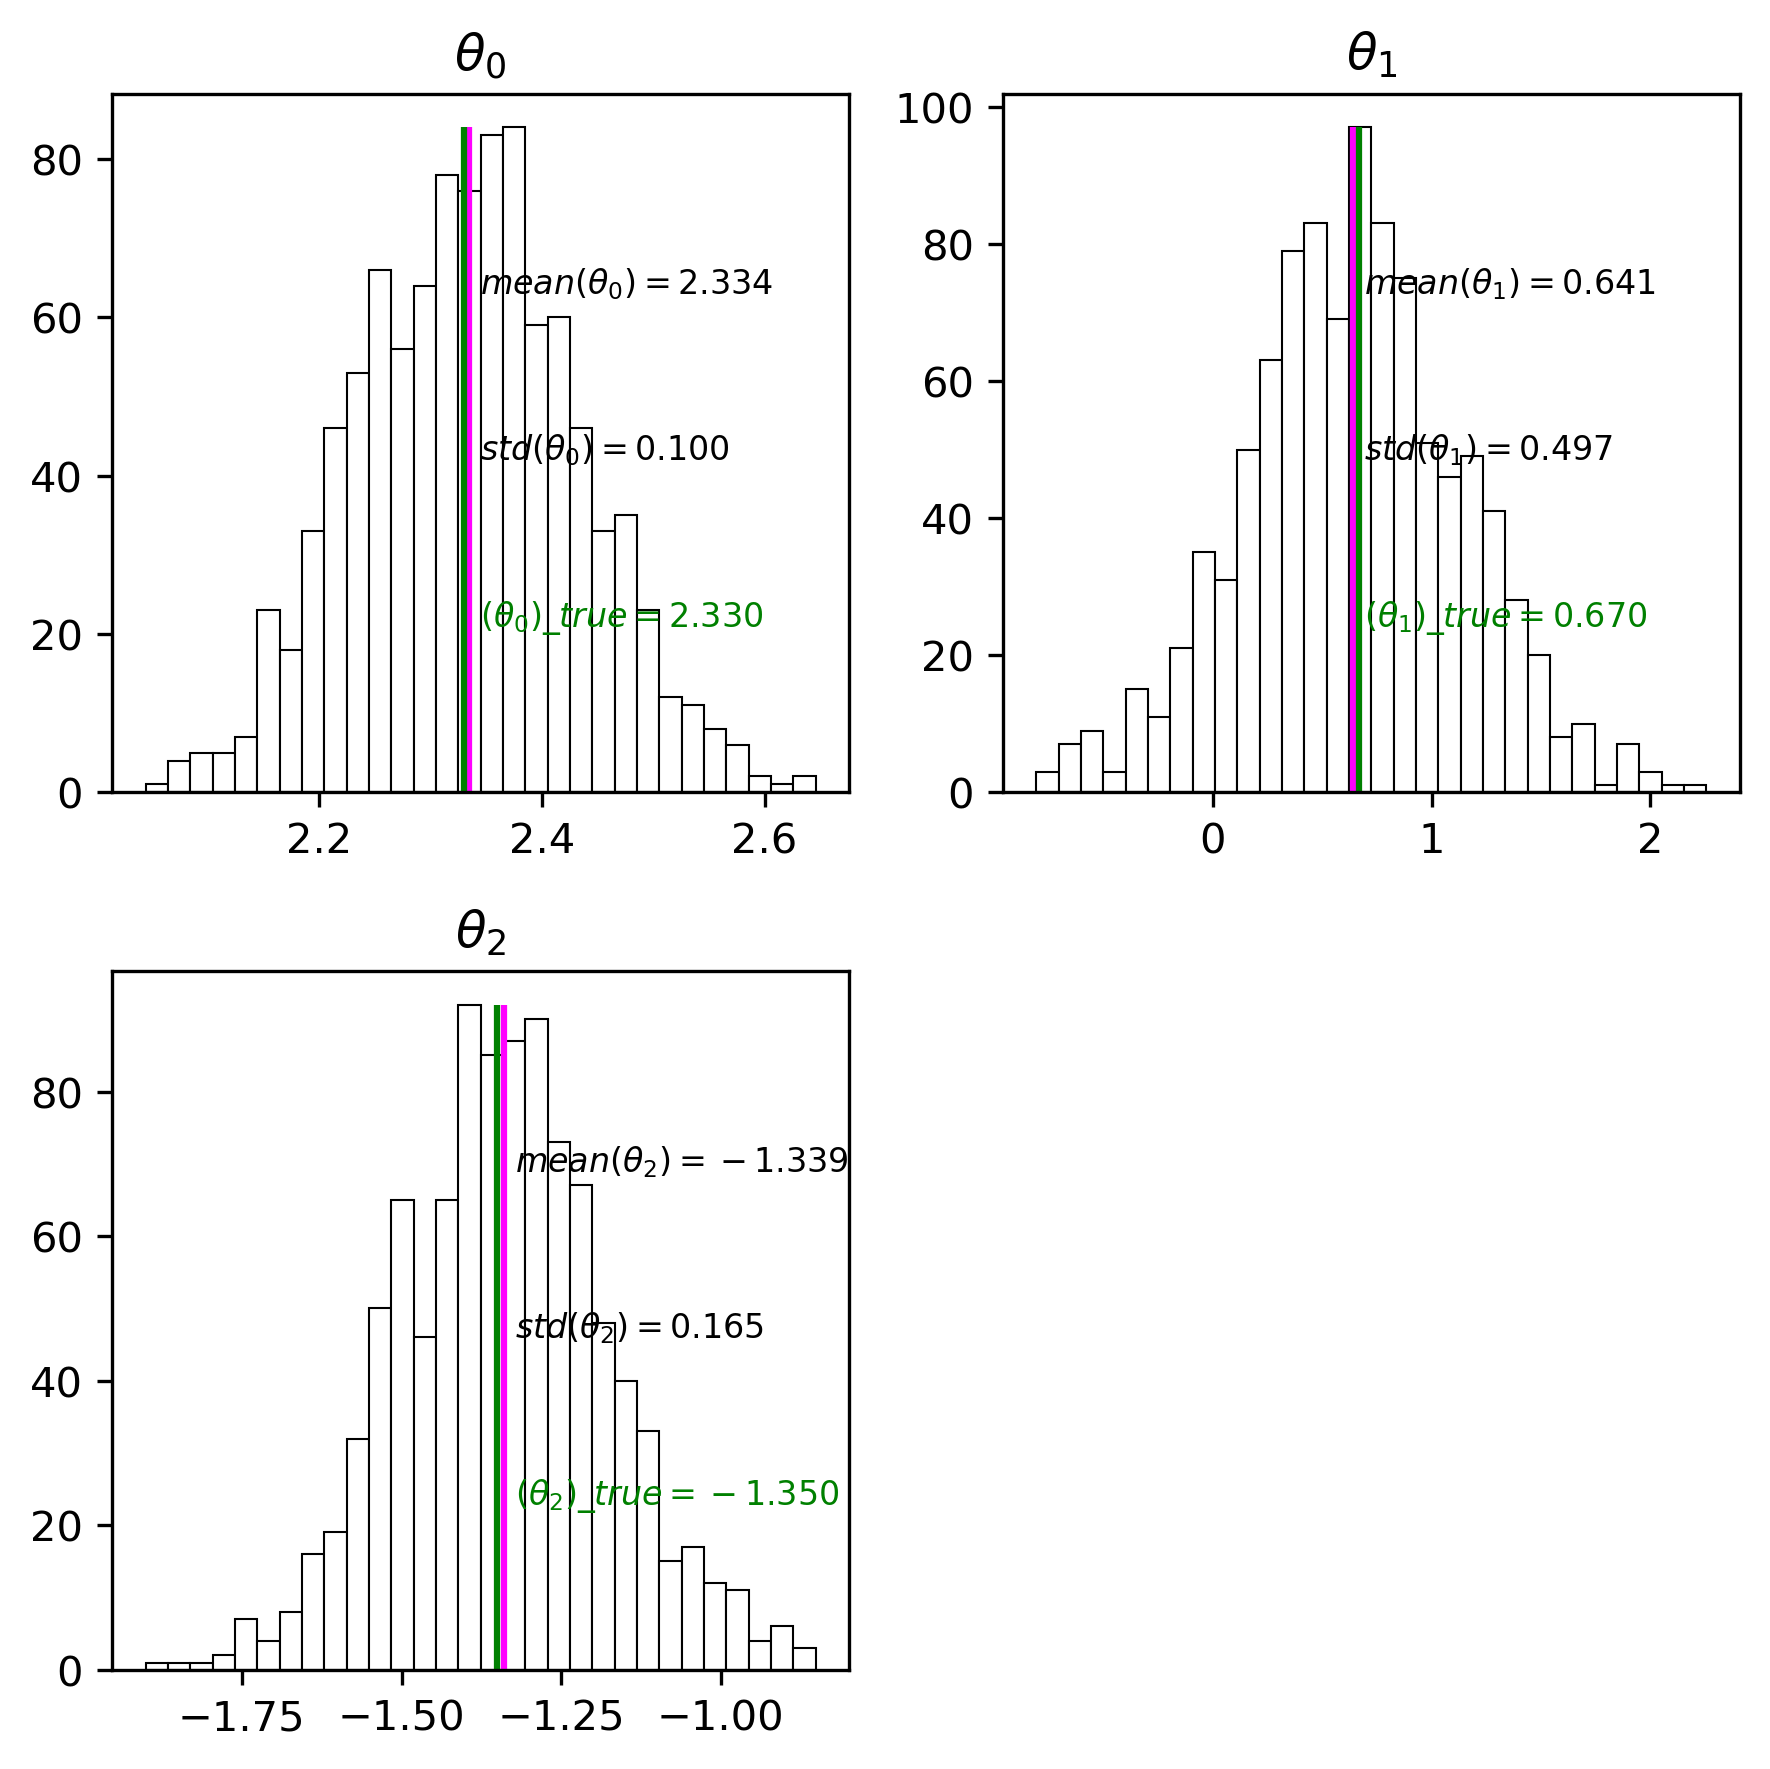

In [26]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(3):
    _ = plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    _ = plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    _ = plt.vlines(theta_true[0,i], 0, h_counts.max(), color='green')
    _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 1*h_counts.max()/4, '$(\\theta_%d)\_true = %.3f$' % (i, theta_true[0,i]), fontsize=8, color='green', weight='bold')
_ = plt.tight_layout()

<br />

In [27]:
sample_size = 1000
theta_values_curr_sample_size = []
for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7953.82it/s]


In [28]:
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 3)

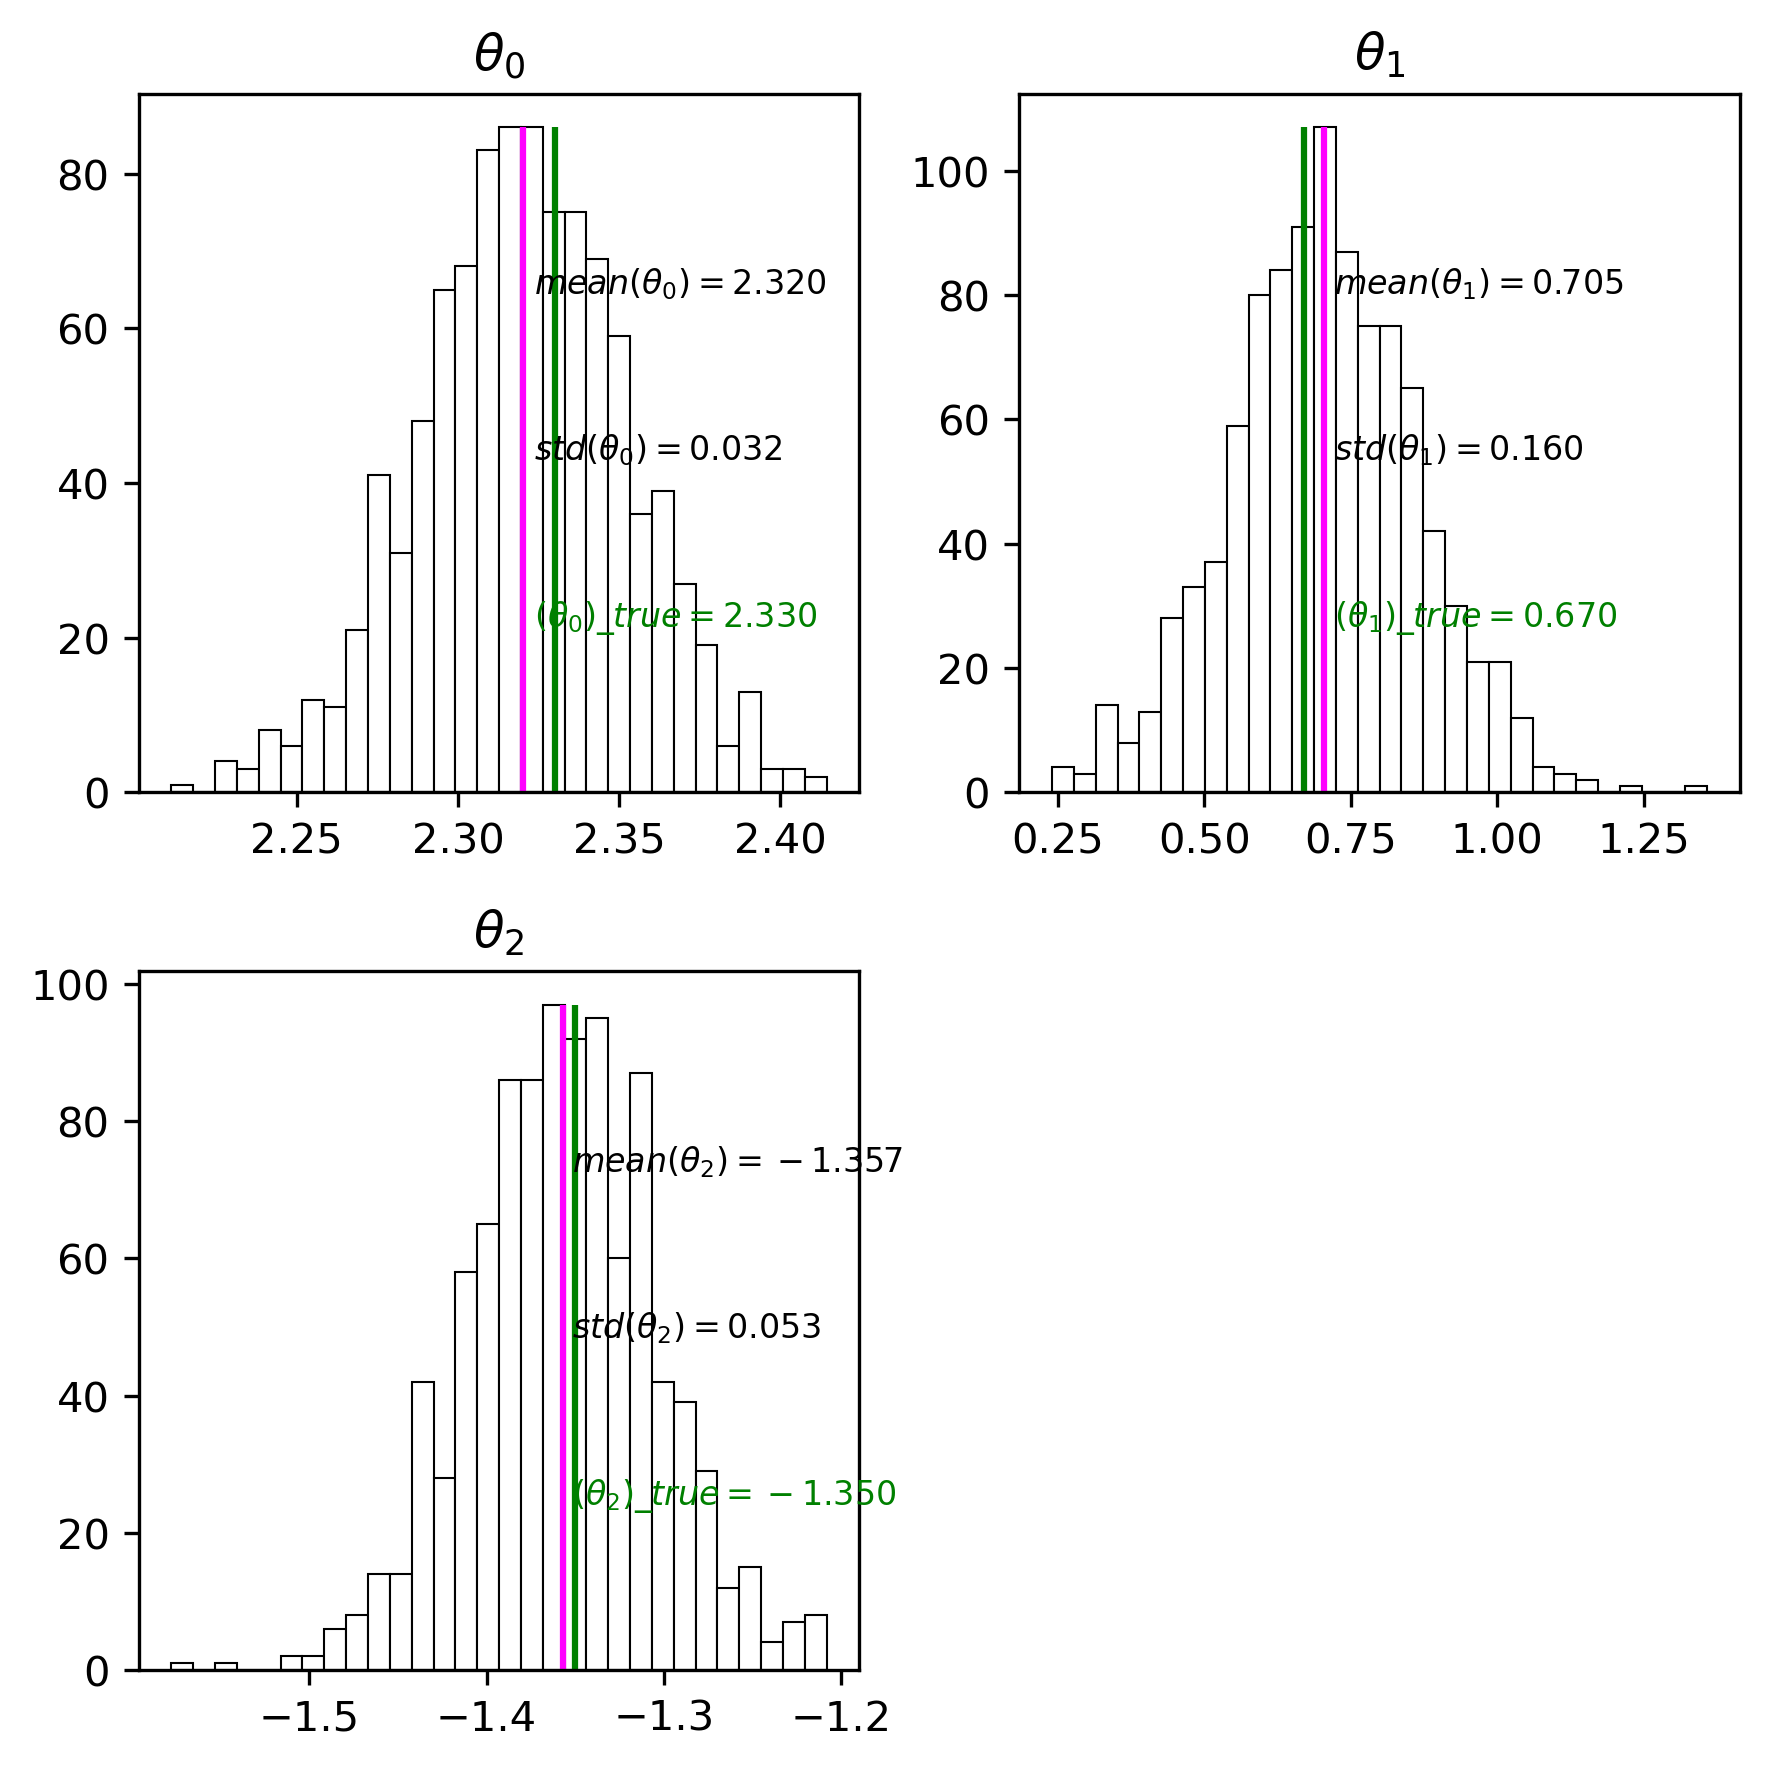

In [29]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(3):
    _ = plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    _ = plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    _ = plt.vlines(theta_true[0,i], 0, h_counts.max(), color='green')
    _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 1*h_counts.max()/4, '$(\\theta_%d)\_true = %.3f$' % (i, theta_true[0,i]), fontsize=8, color='green', weight='bold')
_ = plt.tight_layout()

<br />

## неопределенность параметров в зависимости от размера bootstrap-выборки

In [27]:
theta_values_per_sample_size = []
for sample_size in [2**i for i in range(2, 14)]:
    theta_values_curr_sample_size = []
    for i in tqdm(range(B), total=B):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
        lr = linear_regression()
        lr.fit(Xtrain,ytrain)
        theta_values_curr_sample_size.append(np.copy(lr.theta))
    theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
    theta_values_per_sample_size.append({'sample_size': sample_size, 'theta_values': theta_values_curr_sample_size})

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2067.89it/s]


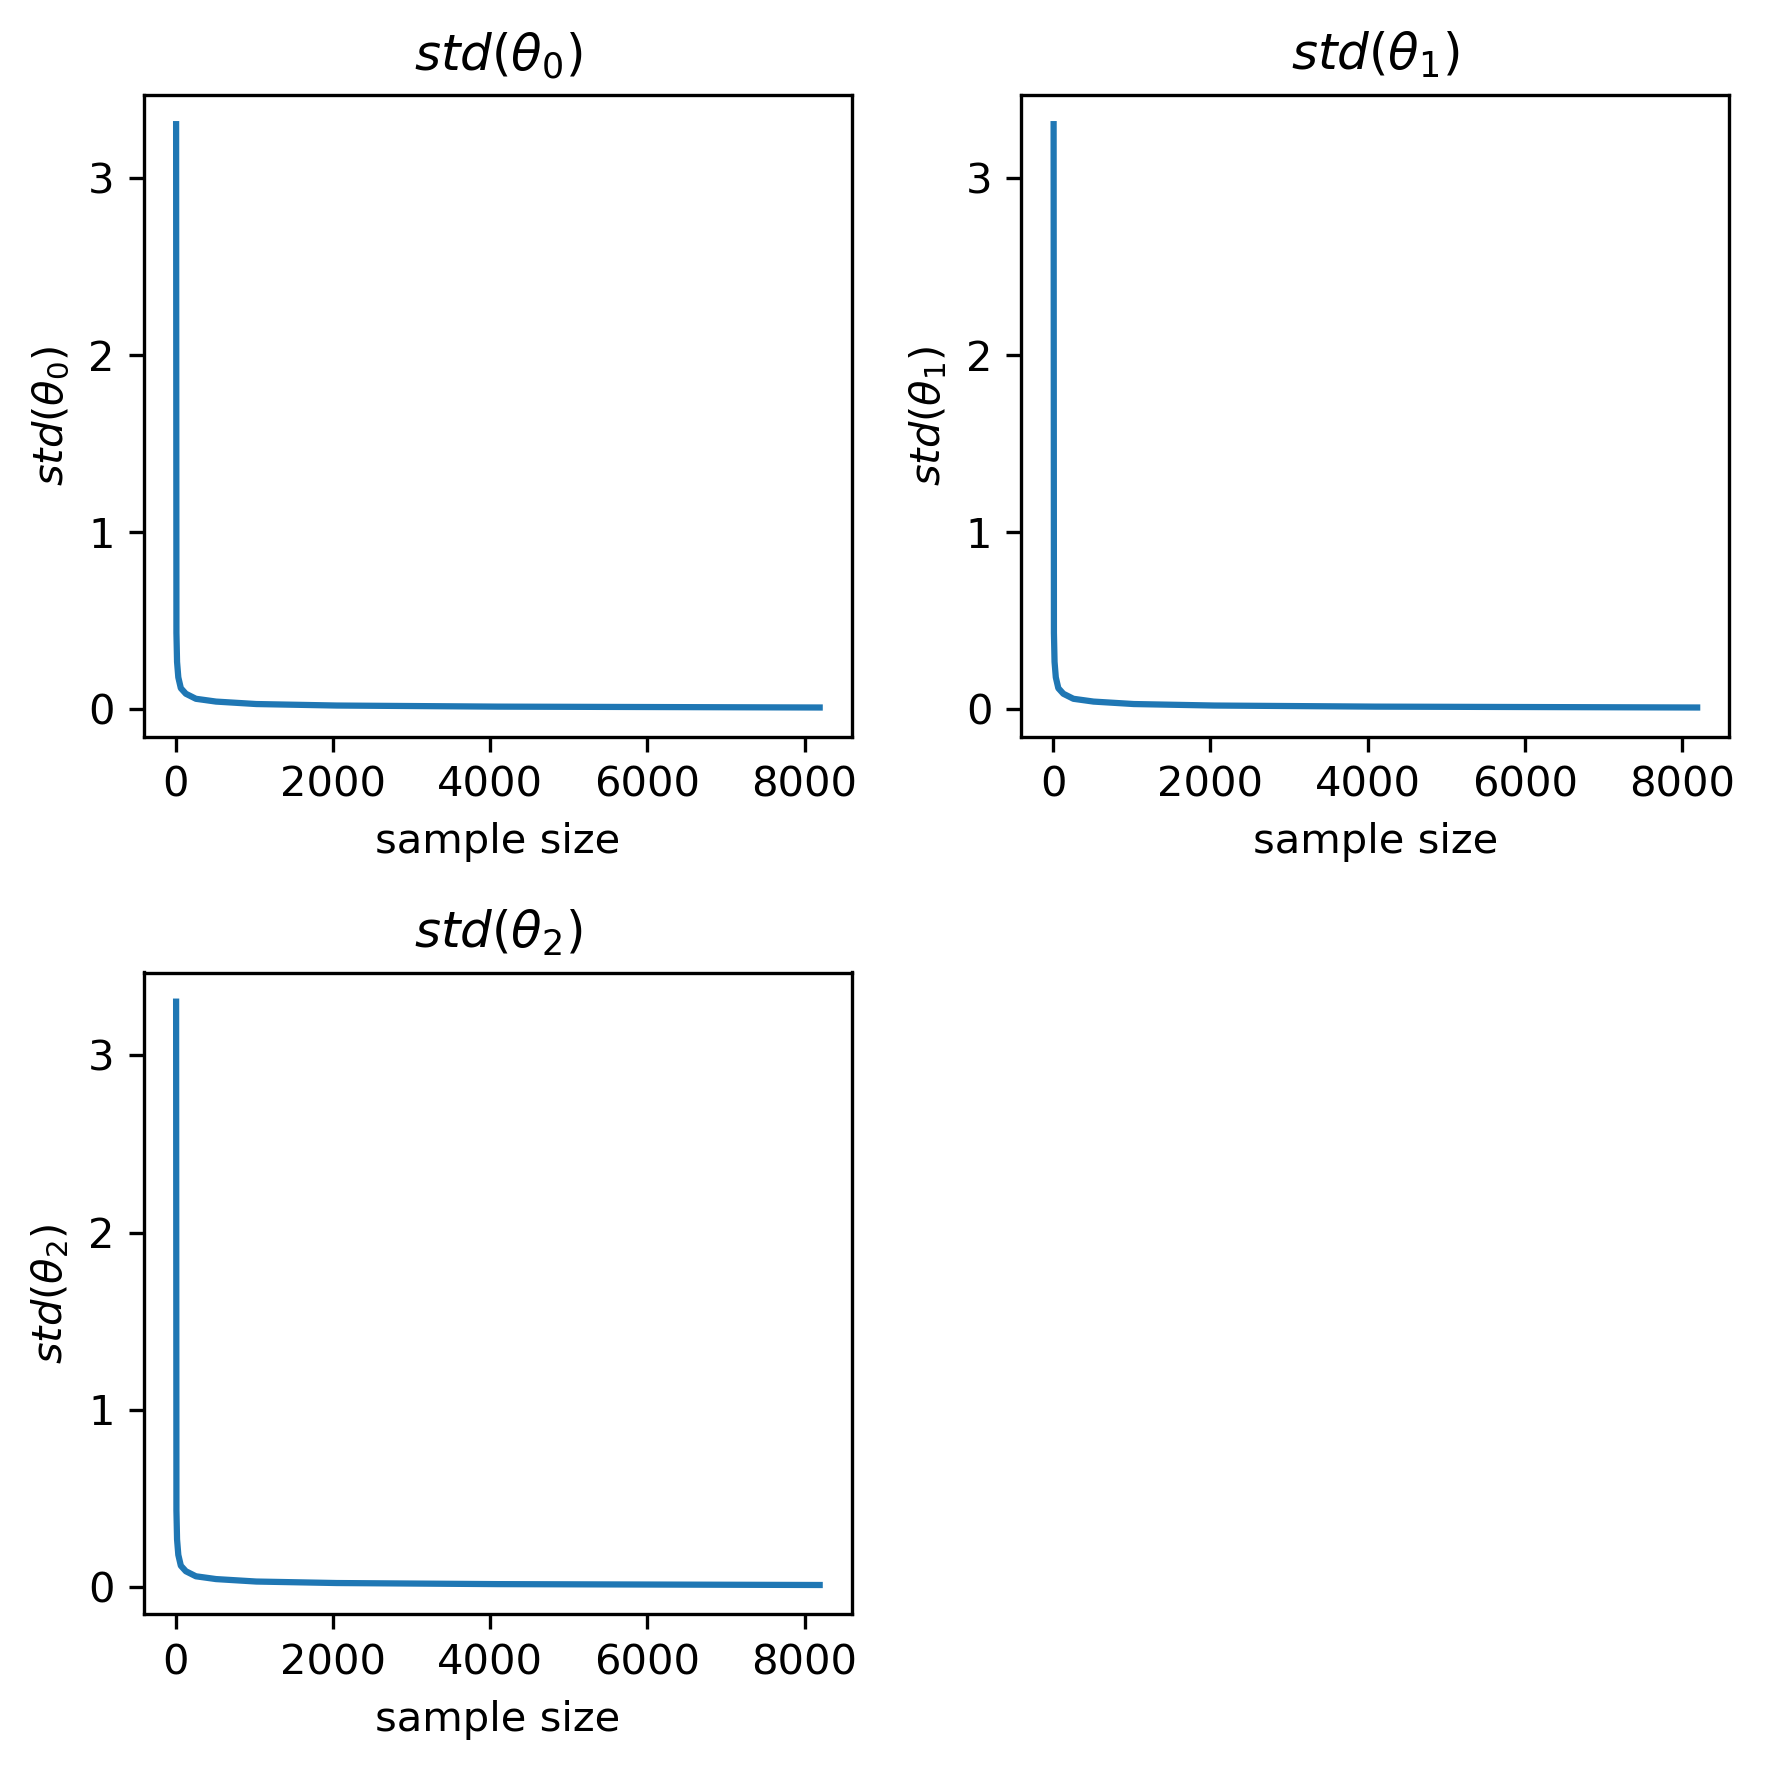

In [28]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(3):
    _ = plt.subplot(2,2,i+1)
    _ = plt.plot([t['sample_size'] for t in theta_values_per_sample_size],
                 [np.std(t['theta_values'][:,0]) for t in theta_values_per_sample_size],
                 label='$std(\\theta_%d)$' % i)
    _ = plt.ylabel('$std(\\theta_%d)$' % i)
    _ = plt.xlabel('sample size')
    _ = plt.title('$std(\\theta_%d)$' % i)
plt.tight_layout()

## ВЫВОДЫ?

<br /><br /><br />